<a href="https://colab.research.google.com/github/jsandino/covid19-to/blob/main/covid19_to.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

For the *Ingest* phase, load the covid-19 data table as published by  Toronto Public Health.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
random.seed(10)

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Load covid-19 data from Toronto Public Health
df = pd.read_csv("https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/64b54586-6180-4485-83eb-81e8fae3b8fe/resource/fff4ee65-3527-43be-9a8a-cb9401377dbc/download/COVID19%20cases.csv")

df.head()

,_id,Assigned_ID,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Ever Hospitalized,Ever in ICU,Ever Intubated
0,1,1,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-22,2020-01-23,FEMALE,RESOLVED,No,No,No
1,2,2,NO,50 to 59 Years,Willowdale East,M2N,Travel,CONFIRMED,2020-01-21,2020-01-23,MALE,RESOLVED,Yes,No,No
2,3,3,NO,20 to 29 Years,Parkwoods-Donalda,M3A,Travel,CONFIRMED,2020-02-05,2020-02-21,FEMALE,RESOLVED,No,No,No
3,4,4,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-16,2020-02-25,FEMALE,RESOLVED,No,No,No
4,5,5,NO,60 to 69 Years,Church-Yonge Corridor,M4W,Travel,CONFIRMED,2020-02-20,2020-02-26,MALE,RESOLVED,No,No,No


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414830 entries, 0 to 414829
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   _id                  414830 non-null  int64 
 1   Assigned_ID          414830 non-null  int64 
 2   Outbreak Associated  414830 non-null  object
 3   Age Group            414408 non-null  object
 4   Neighbourhood Name   401131 non-null  object
 5   FSA                  406602 non-null  object
 6   Source of Infection  414830 non-null  object
 7   Classification       414830 non-null  object
 8   Episode Date         414830 non-null  object
 9   Reported Date        414830 non-null  object
 10  Client Gender        414830 non-null  object
 11  Outcome              414830 non-null  object
 12  Ever Hospitalized    414830 non-null  object
 13  Ever in ICU          414830 non-null  object
 14  Ever Intubated       414830 non-null  object
dtypes: int64(2), object(13)
memory usa

In [ ]:
df.describe()

,_id,Assigned_ID
count,414830.000000,414830.000000
mean,207415.500000,213965.461681
std,119751.250421,122936.270595
min,1.000000,1.000000
25%,103708.250000,108021.250000
50%,207415.500000,214326.500000
75%,311122.750000,320157.750000
max,414830.000000,426683.000000


## EDA

In the *Exploratory Data Analysis* phase, it is desirable to understand the structure of the data.  This will allow the preparation of a subset to be used to construct the model.

In [4]:
import datetime
import re

### Filter and prepare data of interest


---



**Episode Date**

Start by adding a *Recency* column derived from the episode date.  In this context, recency refers to the number of days from when the episode was identified to the present date (ie. high recency corresponds to older cases dating back to early 2021)

In [5]:
case_df = df.copy()

def recency_from(val) -> int:
    result = re.search(r'\d{4}-\d{2}-\d{2}', str(val))
    episode_date = datetime.date.fromisoformat(result[0])
    return (datetime.date.today() - episode_date).days

case_df["Recency"] = case_df["Episode Date"].map(recency_from)
case_df[["Episode Date", "Recency"]].head()

,Episode Date,Recency
0,2020-01-22,1698
1,2020-01-21,1699
2,2020-02-05,1684
3,2020-02-16,1673
4,2020-02-20,1669




---


**Age Group**

Remap *Age Group* to a numeric representation; each number representing an age group in ascending order:

In [6]:
# Represent *Age Group* as a number, by concatenating age limits:
#
# def encode_ages(val) -> int:
#   match = re.search(r"(\d+)\s*(?:to|and)\s*(\d+)?", str(val))
#   if match:
#     low_bound = match[1]
#     hi_bound = match[2] if match[2] else 0
#     result = int(f'{low_bound}{hi_bound}')
#     # Adjust result for cases where only a low bound is present
#     return result if hi_bound else result * 10

#   return float('nan')

# case_df["Ages"] = case_df["Age Group"].map(encode_ages)
# case_df[["Age Group", "Ages"]].head()

age_mapping = {k:v for v, k in enumerate(case_df.sort_values(["Age Group"])["Age Group"].unique()) if not pd.isna(k)}
case_df["Ages"] = case_df["Age Group"].map(age_mapping)
case_df[["Age Group", "Ages"]].head()

print(age_mapping)


{'19 and younger': 0, '20 to 29 Years': 1, '30 to 39 Years': 2, '40 to 49 Years': 3, '50 to 59 Years': 4, '60 to 69 Years': 5, '70 to 79 Years': 6, '80 to 89 Years': 7, '90 and older': 8}


Clean up the *Ages* column by dropping any NA values:

In [7]:
# case_df.info()
ages_nan_count = case_df["Ages"].isna().sum()
print(f'Ages with NA values (before): {ages_nan_count}')

case_df.dropna(inplace=True)

ages_nan_count = case_df["Ages"].isna().sum()
print(f'Ages with NA values (after): {ages_nan_count}')

Ages with NA values (before): 422
Ages with NA values (after): 0




---

**Client Gender**

Remap *Gender* values to a numeric representation:

In [8]:
gender_mapping = {k:v for v, k in enumerate(case_df["Client Gender"].unique())}

case_df["Gender"] = case_df["Client Gender"].map(gender_mapping)
case_df[["Client Gender", "Gender"]].head()

,Client Gender,Gender
0,FEMALE,0
1,MALE,1
2,FEMALE,0
3,FEMALE,0
4,MALE,1




---

**Outcome**

Remap *Outcome* to a numeric representation:


In [9]:
outcome_mapping = {k:v for v, k in enumerate(case_df["Outcome"].unique())}
print(outcome_mapping)

case_df["Outcome"] = case_df["Outcome"].map(outcome_mapping)
case_df["Outcome"].head()

{'RESOLVED': 0, 'FATAL': 1, 'ACTIVE': 2}


,Outcome
0,0
1,0
2,0
3,0
4,0




---

**Parameter Selection**

Select only the columns of interest:


In [10]:
case_df = case_df[["Recency", "Ages", "Gender", "Outcome"]]
case_df.head()

,Recency,Ages,Gender,Outcome
0,1698,4.0,0,0
1,1699,4.0,1,0
2,1684,1.0,0,0
3,1673,5.0,0,0
4,1669,5.0,1,0


## Modeling



### 1. Data Preparation

A quick inspection of the 4 parameters in question reveals that *Recency* is significantly larger than *Ages*, *Gender* and *Outcome*.  To prevent our model from being skewed towards one set of parameters, we need to scale them:


In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

normalized_cases = scaler.fit_transform(case_df)
norm_case_df = pd.DataFrame(normalized_cases, columns=["Recency", "Ages", "Gender", "Outcome"])
norm_case_df.head()

,Recency,Ages,Gender,Outcome
0,0.999326,0.500,0.000,0.0
1,1.000000,0.500,0.125,0.0
2,0.989892,0.125,0.000,0.0
3,0.982480,0.625,0.000,0.0
4,0.979784,0.625,0.125,0.0


### 2. Preliminary Clustering

In [12]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=8)
model.fit(normalized_cases)
case_df["Cluster"] = model.fit_predict(norm_case_df)
case_df.head(10)


,Recency,Ages,Gender,Outcome,Cluster
0,1698,4.0,0,0,2
1,1699,4.0,1,0,2
2,1684,1.0,0,0,0
3,1673,5.0,0,0,3
4,1669,5.0,1,0,3
5,1665,4.0,1,0,2
6,1669,7.0,1,0,3
7,1668,5.0,1,0,3
8,1660,4.0,1,0,2
9,1663,5.0,1,0,3


### 3. Analyze cluster sizes

In [13]:
case_df.groupby("Cluster").count()

,Recency,Ages,Gender,Outcome
Cluster,,,,
0,59952,59952,59952,59952
1,50501,50501,50501,50501
2,77842,77842,77842,77842
3,29041,29041,29041,29041
4,68078,68078,68078,68078
5,38088,38088,38088,38088
6,5375,5375,5375,5375
7,72090,72090,72090,72090


### 4. Analyze RAGO Spread

One way to gain intuition about the data, is to analyze the spread of the different parameters being analyzed; in our case, the four parameters are *Recency*, *Ages*, *Gender* and *Outcome* *(RAGO)*

### 5. Plot distributions of the RAGO data

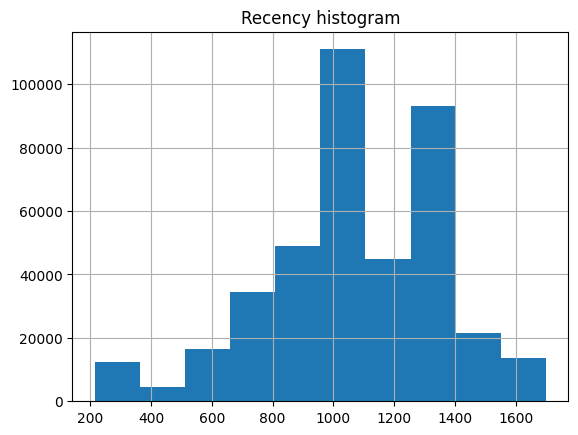

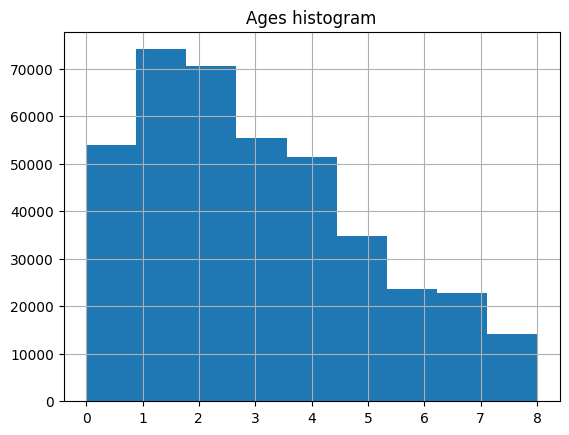

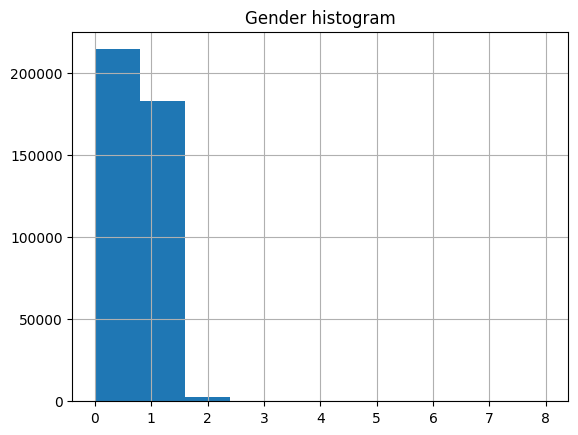

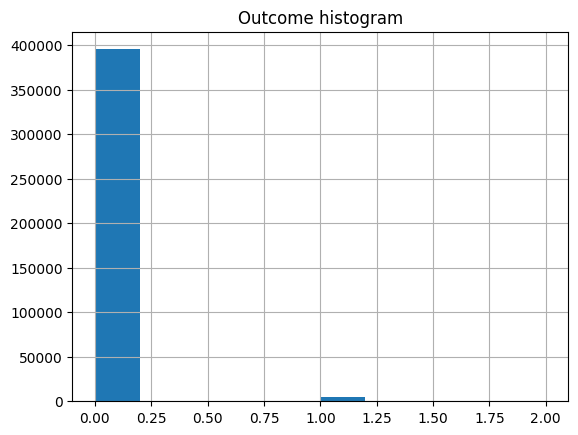

In [14]:
# Plot histograms of each field

case_df['Recency'].hist()
plt.title('Recency histogram')
plt.show()

case_df['Ages'].hist(bins=9)
plt.title('Ages histogram')
plt.show()

case_df['Gender'].hist()
plt.title('Gender histogram')
plt.show()

case_df['Outcome'].hist()
plt.title('Outcome histogram')
plt.show()

### 6. Elbow Plot

Let's inspect an elbow plot for various cluster sizes:

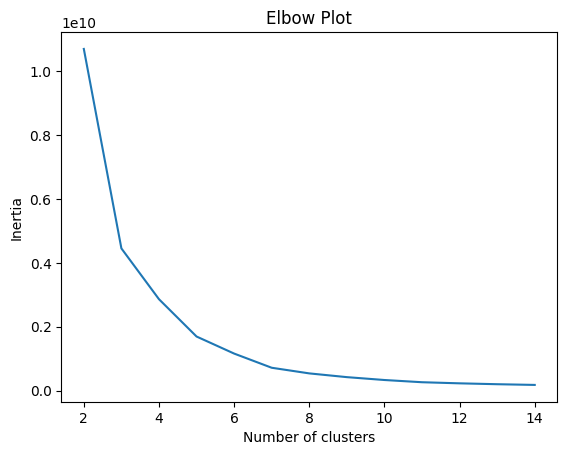

In [15]:
inertias = []
for each in range(2, 15):
    kmeans = KMeans(n_clusters = each)
    kmeans.fit(case_df[["Recency", "Ages", "Gender", "Outcome"]])
    inertias.append(kmeans.inertia_)

plt.plot(range(2,15), inertias)
plt.title("Elbow Plot")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

The elbows at 5 and 7 clusters seem like good choices: a balance of low inertia and (relative) low complexity (ie number of clusters)

### 7. Build the Model

Build two more models: one with 5 clusters, one with 7 clusters:

In [16]:
kmeans5_model = KMeans(n_clusters = 5)
kmeans7_model = KMeans(n_clusters = 7)

case_df["Cluster5"] = kmeans5_model.fit_predict(normalized_cases)
case_df["Cluster7"] = kmeans7_model.fit_predict(normalized_cases)

case_df.head()

,Recency,Ages,Gender,Outcome,Cluster,Cluster5,Cluster7
0,1698,4.0,0,0,2,1,1
1,1699,4.0,1,0,2,1,1
2,1684,1.0,0,0,0,4,5
3,1673,5.0,0,0,3,1,1
4,1669,5.0,1,0,3,1,1


Cluster 5 counts:

In [17]:
case_df.groupby("Cluster5")["Cluster5"].count()

,Cluster5
Cluster5,
0,109335
1,56950
2,73760
3,47500
4,113422


Cluster 7 counts:

In [18]:
case_df.groupby("Cluster7")["Cluster7"].count()

,Cluster7
Cluster7,
0,72651
1,63893
2,50658
3,68304
4,22013
5,88699
6,34749


Now let's compare how drastic it would be to move from 5 clusters to 7 clusters:

In [166]:
pd.crosstab(case_df["Cluster5"], case_df["Cluster7"]).style.background_gradient(axis=1, cmap="Blues")

Cluster7,0,1,2,3,4,5,6
Cluster5,,,,,,,
0,0,1,698,31102,0,41374,539
1,0,4750,0,0,0,8593,34210
2,579,0,0,40452,68304,0,0
3,88120,0,24202,1097,0,0,0
4,0,17262,38993,0,0,691,0


Looks like:

* Cluster 0 would be (more or less) split evenly into two clusters (3 and 5)
* Cluster 1 would remain (mostly) unchanged (as cluster 6)
* Cluster 2 would be split (mostly) into two clusters (3 and 4)
* Cluster 3 would remain (mostly) unchanged (as cluster 0), with a bit going into cluster 2
* Cluster 4 would be split (mostly) into two clusters (1 and 2)



### 8. Analyze the Model

Since the 7 cluster model isn't drastically different, we'll use 5 clusters for model analysis.

Start by constructing a decision tree for the given cluster:

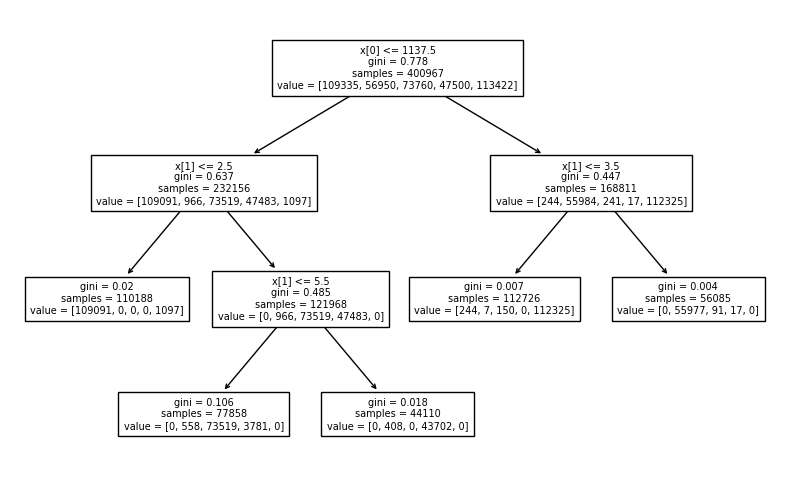

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_model = DecisionTreeClassifier(min_impurity_decrease=0.1)
tree_model.fit(case_df[["Recency", "Ages", "Gender", "Outcome"]], case_df["Cluster5"])

plt.figure(figsize=(10,6))
plot_tree(tree_model, fontsize=7);

From the tree, we can see:

* Cluster 1 (109,091): cases within the last 3 years, patients under 40 years of age
* Cluster 2 (73,519): cases within the last 3 years, patients between 40 and 70 years of age
* Cluster 3 (43,702): cases within the last 3 years, patients over 70 years of age
* Cluster 4 (112,325): cases older than 3 years, patients under 50 years of age
* Cluster 5 (55,977): cases older than 3 years, patients over 50 years of age



## Conclusion

*Recency* is the most suitable metric to initially split the data, using a decision boundary of about 3 years.  Then *Ages* becomes more useful for grouping patients, using decision boundaries approximately of 40, 70 and 50